In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv("Excitation.csv")

# Drop the first column (assuming it's the first column by index)
df_dropped = df.drop(df.columns[0], axis=1)

# Convert the DataFrame to a NumPy array
force_array = np.array(df_dropped).T

In [3]:
force_array

array([[ 1.49014246, -0.4147929 ,  1.94306561, ..., -0.57101603,
        -2.62685476, -4.14839919],
       [ 2.77853264,  5.72824992, -4.19570272, ...,  1.92252858,
        -1.71353697,  1.71774834],
       [ 4.19806631,  2.77390105,  0.17889111, ...,  3.62509869,
         3.07218758,  1.77758085],
       ...,
       [ 0.06212605, -3.20618086, -0.41675141, ...,  0.63019084,
         0.616964  ,  1.61468794],
       [-2.01412056, -2.1413984 ,  4.2762178 , ...,  3.62332948,
        -3.16991464,  2.23638436],
       [ 0.17047219,  0.4997595 ,  1.87686869, ...,  2.90333658,
         1.87107963,  0.04675372]])

In [4]:
df = pd.read_csv("Displacement.csv")

# Drop the first column (assuming it's the first column by index)
df_dropped = df.drop(df.columns[0], axis=1)

# Convert the DataFrame to a NumPy array
displacement_array = np.array(df_dropped).T

In [5]:

# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [6]:


# Scale data
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))



# Flatten for scaling
X_flattened = force_array.reshape(-1, 1)  
y_flattened = displacement_array.reshape(-1, 1)  

scaler_X.fit(X_flattened)
scaler_y.fit(y_flattened)

# Scale the data
X_scaled = scaler_X.transform(X_flattened)  # Shape: (25000, 1)
y_scaled = scaler_y.transform(y_flattened)  # Shape: (25000, 1)

# Reshape back to original dimensions
X_scaled = X_scaled.reshape(force_array.shape)  
y_scaled = y_scaled.reshape(displacement_array.shape)  



In [7]:
print(X_scaled.shape, y_scaled.shape)

(50, 500) (50, 500)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_scaled,y_scaled, test_size=0.2, random_state=42)

In [9]:
def create_sequences(force_data,disp_data, window_size):
    X = []
    y = []
    for i in range(force_data.shape[0]):
        for j in range(force_data.shape[1] - window_size):
            X.append(force_data[i, j:j + window_size]) # first 30, tyo paxi arko 30 
            y.append(disp_data[i, j + window_size]) # 30 th 
    return np.array(X), np.array(y)

In [10]:
# def create_sequences(X_data0, y_data0, window_size):
#     X_new_temp = []
#     y_new_temp = []
#     for ii in range(len(X_data0)):
#         X_temp = X_data0[ii]
#         y_temp = y_data0[ii]
#         X_new = []
#         y_new = []
#         for jj in range(int(np.floor(len(X_temp) / window_size))):
#             X_new.append(X_temp[jj * window_size:(jj + 1) * window_size])
#             y_new.append(y_temp[(jj + 1) * window_size - 1])
#             # y_new.append(y_temp[(jj + 1) * window_size - 1])

#         X_new_temp.append(np.array(X_new))
#         y_new_temp.append(np.array(y_new))

#     X_data_new0 = np.array(X_new_temp)
#     y_data_new0 = np.array(y_new_temp)

#     return X_data_new0, y_data_new0

In [11]:
window_size = 100  # Example window size
X_train_LSTM, y_train_LSTM = create_sequences(X_train, y_train, window_size)
# X_val_LSTM, y_val_LSTM = create_sequences(X_val, y_val, window_size)
X_test_LSTM, y_test_LSTM = create_sequences(X_test, y_test, window_size)
y_train_LSTM = y_train_LSTM.reshape(-1, 1)  # Ensure y has the correct shape
# y_val_LSTM = y_val_LSTM.reshape(-1, 1)  # Ensure y has the correct shape
y_test_LSTM = y_test_LSTM.reshape(-1, 1)  # Ensure y has the correct shape

In [12]:
y_test_LSTM.shape

(4000, 1)

In [13]:
y_train_LSTM.shape

(16000, 1)

In [14]:
X_train_LSTM.shape

(16000, 100)

In [15]:
X_train_LSTM = X_train_LSTM.reshape((X_train_LSTM.shape[0], X_train_LSTM.shape[1], 1))

In [16]:
# X_val_LSTM = X_val_LSTM.reshape((X_val_LSTM.shape[0], X_val_LSTM.shape[1], 1))

In [17]:
from keras.regularizers import l1, l2
# Define the RMSprop optimizer
# rmsprop = RMSprop(learning_rate=0.001)
def create_model():
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train_LSTM.shape[1],X_train_LSTM.shape[2]), kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True,kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(100))
    # model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [18]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 activation (Activation)     (None, 100, 100)          0         
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          80400     
                                                                 
 activation_1 (Activation)   (None, 100, 100)          0         
                                                                 
 dense (Dense)               (None, 100, 1)            101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 12130

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the callbacks
checkpoint = ModelCheckpoint('best_model_window1.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

In [20]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5, shuffle=True, random_state=1)
# for train_index, val_index in kf.split(X_train_LSTM):
#     X_train, X_val = X_train_LSTM[train_index], X_train_LSTM[val_index]
#     y_train, y_val = y_train_LSTM[train_index], y_train_LSTM[val_index]
# y_val.shape

In [22]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=1, shuffle=True, random_state=42)
# for train_index, val_index in kf.split(X_train_LSTM):
X_train_L, X_val_L, y_train_L, y_val_L = train_test_split(X_train_LSTM,y_train_LSTM, test_size=0.2, random_state=42)
    
model = create_model()
history = model.fit(X_train_L, y_train_L, epochs=50, batch_size=32, validation_data= (X_val_L, y_val_L), callbacks=[checkpoint, early_stopping], shuffle= True)

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 0.1944 - mse: 0.0640
Epoch 1: val_loss improved from inf to 0.06032, saving model to best_model_window1.h5
400/400 [==============================] - 35s 81ms/step - loss: 0.1944 - mse: 0.0640 - val_loss: 0.0603 - val_mse: 0.0573
Epoch 2/50
  2/400 [..............................] - ETA: 28s - loss: 0.0592 - mse: 0.0562

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - ETA: 0s - loss: 0.0645 - mse: 0.0617
Epoch 2: val_loss improved from 0.06032 to 0.05854, saving model to best_model_window1.h5
400/400 [==============================] - 31s 77ms/step - loss: 0.0645 - mse: 0.0617 - val_loss: 0.0585 - val_mse: 0.0560
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 0.0638 - mse: 0.0613
Epoch 3: val_loss did not improve from 0.05854
400/400 [==============================] - 31s 77ms/step - loss: 0.0638 - mse: 0.0613 - val_loss: 0.0631 - val_mse: 0.0611
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 0.0628 - mse: 0.0606
Epoch 4: val_loss did not improve from 0.05854
400/400 [==============================] - 31s 77ms/step - loss: 0.0628 - mse: 0.0606 - val_loss: 0.0596 - val_mse: 0.0576
Epoch 5/50
400/400 [==============================] - ETA: 0s - loss: 0.0631 - mse: 0.0609
Epoch 5: val_loss did not improve from 0.05854
400/400 [==============================] - 30s 

In [23]:
# Train the model with the callbacks
# history = model.fit(X_train_LSTM, y_train_LSTM, epochs=500, batch_size=10, validation_data=(X_val_LSTM,y_val_LSTM),callbacks=[checkpoint, early_stopping],shuffle=True)

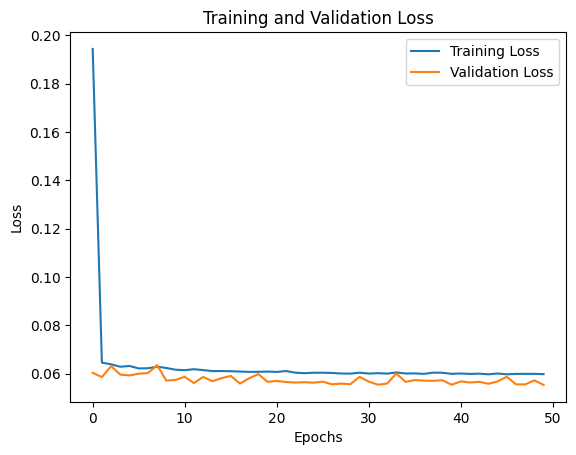

In [24]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.ylim([0,0.08])
plt.savefig("Training_Val_loss_sliding_window.jpg")
plt.show()

In [25]:
X_test_LSTM.shape

(4000, 100)

In [26]:
from tensorflow.keras.models import load_model

In [27]:
model= load_model("best_model_window1.h5")

In [28]:
X_test_LSTM = X_test_LSTM.reshape((X_test_LSTM.shape[0], X_test_LSTM.shape[1], 1))

In [29]:
X_test_LSTM.shape

(4000, 100, 1)

In [30]:
y_test_LSTM.shape

(4000, 1)

In [31]:
X_train_LSTM.shape

(16000, 100, 1)

In [32]:
y_train_LSTM.shape

(16000, 1)

In [33]:
# Evaluate the model
test_loss = model.evaluate(X_test_LSTM, y_test_LSTM)

# Make predictions
y_pred = model.predict(X_test_LSTM)
y_pred_reshaped = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])


# Inverse transform predictions to original scale
y_pred_inverse = scaler_y.inverse_transform(y_pred_reshaped)
y_test_inverse = scaler_y.inverse_transform(y_test_LSTM)

125/125 [==============================] - 3s 18ms/step


In [34]:
y_pred.shape

(4000, 100, 1)

In [35]:
y_pred_inverse.shape

(4000, 100)

In [36]:
ypred_inv = y_pred_inverse.flatten()
ytest_inv = y_test_inverse.flatten()

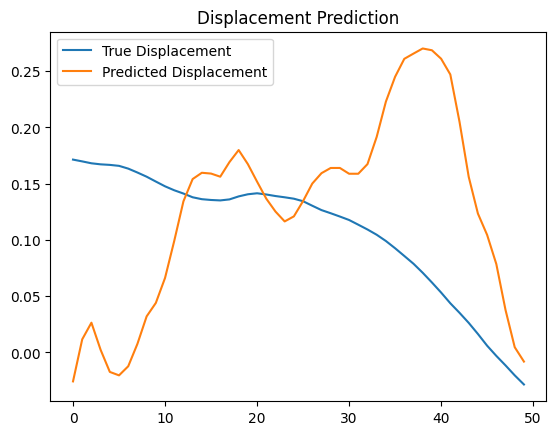

In [37]:
# Visualize results
plt.figure()
plt.plot(ytest_inv[0:50], label='True Displacement')
plt.plot(ypred_inv[0:50], label='Predicted Displacement')
# plt.plot(y_test[1], label= "True True")
plt.title('Displacement Prediction')
plt.legend()

plt.savefig("TruedispVsPredictedDisp.jpg")
plt.show()

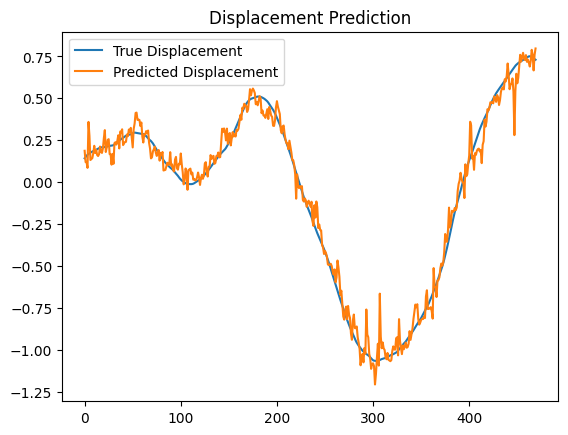

In [161]:
""""
The very first time I reached here, I dont know why I cannot tune hyperparameters to achive this.
"""



plt.figure()
plt.plot(disp_test_inv, label='True Displacement')
plt.plot(y_pred_inv, label='Predicted Displacement')
plt.title('Displacement Prediction')
plt.legend()

plt.savefig("TruedispVsPredictedDispTest.jpg")
plt.show()